In [108]:
import numpy as np
from mpmath import nsum, nprod, fac
from statistics import mean
import matplotlib.pyplot as plt

In [109]:
def print_parameters(p_denial, Q, A, D):
    print('\nDenial probability: ', p_denial)
    print('Relative volume: ', Q)
    print('Absolute volume:', A)
    print('Income:', D)

In [110]:
class RequestSubmit:
    def __init__(self, timepoint, type_of_request):
        self.timepoint = timepoint
        self.type_of_request = type_of_request

In [111]:
class RequestProcess:
    def __init__(self, start_timepoint, timepoint, terminal_no, type_of_request):
        self.start_timepoint = start_timepoint
        self.timepoint = timepoint
        self.terminal_no = terminal_no
        self.type_of_request = type_of_request

In [115]:
class CharacteristicsShower():
    def __init__(self, model):
        self.model = model
    
    def empirical(self):
        print('\nEmpirical characteristics:')
        
        print('Processed requests: ', self.model.requests_processed)
        print('Denied requests: ', self.model.requests_denied)

        probs, ps = self.calculate_probs_emp()

        p_denial, Q, A, D = self.calculate_Q_A_D(ps, 'empirical')
        
        print_parameters(p_denial, Q, A, D)
        
        return probs
        
    def theoretical(self):
        print('\nTheoretical characteristics:')
        
        ro = self.model.intensity_flow / self.model.intensity_flow_service
        p0 = 1 / (nsum(lambda k: ro ** k / fac(k), [0, self.model.number_of_channels]))

        print(f'Probability is equal to {p0} when 0 terminals are busy')
        
        ps, probs = self.calculate_probs_theor(p0, ro)
        
        p_denial, Q, A, D = self.calculate_Q_A_D(ps, 'theoretical')
        
        print_parameters(p_denial, Q, A, D)
 
        return probs

    def calculate_Q_A_D(self, ps, char_type):
        p_denial = ps
        Q = 1 - p_denial
        A = self.model.intensity_flow * Q
        D = A * self.model.income_from_one_request

        return p_denial, Q, A, D
    
    def calculate_probs_emp(self):
        probs = []
        for k in range(self.model.number_of_channels + 1):
            pk = self.model.final_state_durations[k] / self.model.timeline[-1].timepoint
            probs.append(pk)
            print(f'Probability is equal to {pk} when {k} terminals are busy')

        return probs, pk
    
    def calculate_probs_theor(self, p0, ro):
        probs = [p0]
        for k in range(1, self.model.number_of_channels + 1):
            pk = ro ** k * p0 / fac(k)
            probs.append(pk)
            print(f'Probability is equal to {pk} when {k} terminals are busy')

        return pk, probs

    def plot_graphs(self):
        empirical_probs = self.empirical()
        theoretical_probs = self.theoretical()
        
        fig, ax = plt.subplots()
        ax.plot(empirical_probs, label='empirical')
        ax.plot(theoretical_probs, label='theoretical')
        ax.legend()
        plt.show()

        fig, ax = plt.subplots(1, 2)
        ax[0].title.set_text('Empirical probabilities')
        ax[0].hist(list(np.arange(0, len(empirical_probs), 1)), weights=empirical_probs)
        ax[1].title.set_text('Theoretical probabilities')
        ax[1].hist(list(np.arange(0, len(theoretical_probs), 1)), weights=theoretical_probs)
        
        plt.show()

In [113]:
class SystemOfMassServiceModel:
    def __init__(self, number_of_channels, intensity_flow, avg_processing_time, intensity_flow_service, income_from_one_request, 
                 maintenance_of_one_channel, max_requests_num):
        self.number_of_channels = number_of_channels
        self.intensity_flow = intensity_flow
        self.avg_processing_time = avg_processing_time
        self.intensity_flow_service = intensity_flow_service
        self.income_from_one_request = income_from_one_request
        self.maintenance_of_one_channel = maintenance_of_one_channel
        self.max_requests_num = max_requests_num

        self.total_income = 0
        
        self.terminal_availabilities = [True for _ in range(number_of_channels)]
        self.busy_terminals = 0
        
        self.timeline = []
        self.final_state_durations = [0] * (number_of_channels + 0 + 1)
        self.state_durations = []
        self.last_state = 0
        self.last_state_change_timepoint = 0

        self.requests_processed = 0
        self.requests_denied = 0

    def modeling(self):
        requests, services = self.get_generated_values()

        self.timeline.append(RequestSubmit(next(requests), 'submitted'))

        self.add_submits_to_timeline(requests)
            
        for event in self.timeline:
            if event.type_of_request == 'submitted':
                terminal_available, terminal_no = self.find_available_terminal()

                if terminal_available:
                    self.process_request(event, services, terminal_no)
                else:
                    self.requests_denied += 1
            else:
                self.make_terminal_available(event)
                self.record_state(event.timepoint)
                
    def add_submits_to_timeline(self, requests):
        for i in range(self.max_requests_num - 1):
            timepoint = self.timeline[len(self.timeline) - 1].timepoint + next(requests)
            self.timeline.append(RequestSubmit(timepoint, 'submitted'))
                
    def make_terminal_available(self, event):
        self.requests_processed += 1
        self.total_income += self.income_from_one_request
        self.busy_terminals -= 1
        self.terminal_availabilities[event.terminal_no] = True
 
    def process_request(self, event, services, terminal_no):
        self.insert(RequestProcess(event.timepoint, event.timepoint + next(services), terminal_no, 'processed'))
        self.record_state(event.timepoint)

    def insert(self, event):
        for i in range(1, len(self.timeline)):
            if event.timepoint > self.timeline[i - 1].timepoint and event.timepoint < self.timeline[i].timepoint:
                self.timeline.insert(i, event)
                break
        else:
            self.timeline.append(event)

    def find_available_terminal(self):
        for i in range(len(self.terminal_availabilities)):
            if self.terminal_availabilities[i]:
                self.busy_terminals += 1
                self.terminal_availabilities[i] = False
                return True, i
        
        return False, -1
                
    def record_state(self, timepoint):
        delta = timepoint - self.last_state_change_timepoint
        self.final_state_durations[self.last_state] += delta

        self.last_state_change_timepoint = timepoint
        self.last_state = self.busy_terminals

        self.state_durations.append((timepoint, self.final_state_durations.copy()))
        
    def generate_values(self, value):
        while True:
            yield np.random.exponential(1 / value)
            
    def get_generated_values(self):
        requests = self.generate_values(self.intensity_flow)
        services = self.generate_values(self.intensity_flow_service)
        
        return requests, services
        
    """
    Numpy suggests using default_rng(), but it doesn't return generator
    and it only makes things harder for us
    
    def get_generated_values(self):
        rng = np.random.default_rng() 
        requests = rng.exponential(1 / self.lambda_, self.max_requests)
        services = rng.exponential(1 / self.mu, self.max_requests)
        waitings = rng.exponential(1 / self.nu, self.max_requests)
        return requests, services, waitings
    """

MODELING WITH THE NEXT PARAMETERS: Number Of Channels = 2, Intensity Flow = 4,       Average Processing Time = 0.8, Income From One Request = 4, Maintenance Of One Channel: 2

Empirical characteristics:
Processed requests:  441
Denied requests:  559
Probability is equal to 0.10896779280544605 when 0 terminals are busy
Probability is equal to 0.3441676998822055 when 1 terminals are busy
Probability is equal to 0.5468645073123484 when 2 terminals are busy

Denial probability:  0.5468645073123484
Relative volume:  0.45313549268765163
Absolute volume: 1.8125419707506065
Income: 7.250167883002426

Theoretical characteristics:
Probability is equal to 0.107296137339056 when 0 terminals are busy
Probability is equal to 0.343347639484979 when 1 terminals are busy
Probability is equal to 0.549356223175966 when 2 terminals are busy

Denial probability:  0.549356223175966
Relative volume:  0.450643776824034
Absolute volume: 1.80257510729614
Income: 7.21030042918455


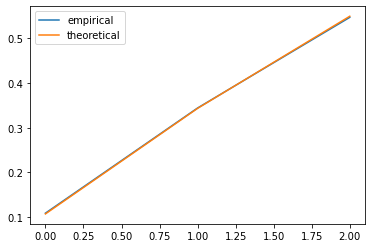

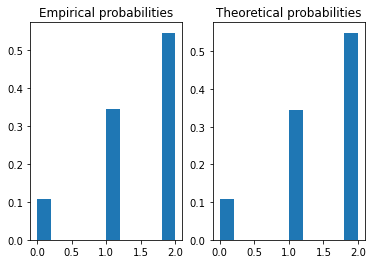

In [134]:
number_of_channels = 2
intensity_flow = 4
avg_processing_time = 0.8
intensity_flow_service = 1 / avg_processing_time
income_from_one_request = 4
maintenance_of_one_channel = 2
max_requests_num = 1000

model = SystemOfMassServiceModel(number_of_channels, intensity_flow, avg_processing_time, intensity_flow_service, income_from_one_request, maintenance_of_one_channel, max_requests_num)
model.modeling()
print(f'MODELING WITH THE NEXT PARAMETERS: Number Of Channels = {model.number_of_channels}, Intensity Flow = {model.intensity_flow}, \
      Average Processing Time = {avg_processing_time}, Income From One Request = {income_from_one_request}, Maintenance Of One Channel: {maintenance_of_one_channel}')
model_characteristics = CharacteristicsShower(model)
model_characteristics.plot_graphs()

MODELING WITH THE NEXT PARAMETERS: Number Of Channels = 3, Intensity Flow = 4,       Average Processing Time = 0.8, Income From One Request = 4, Maintenance Of One Channel: 2

Empirical characteristics:
Processed requests:  652
Denied requests:  348
Probability is equal to 0.06962252601863998 when 0 terminals are busy
Probability is equal to 0.21526022304453143 when 1 terminals are busy
Probability is equal to 0.35070338171739457 when 2 terminals are busy
Probability is equal to 0.3644138692194341 when 3 terminals are busy

Denial probability:  0.3644138692194341
Relative volume:  0.6355861307805659
Absolute volume: 2.5423445231222637
Income: 10.169378092489055

Theoretical characteristics:
Probability is equal to 0.0676528955439293 when 0 terminals are busy
Probability is equal to 0.216489265740574 when 1 terminals are busy
Probability is equal to 0.346382825184918 when 2 terminals are busy
Probability is equal to 0.369475013530579 when 3 terminals are busy

Denial probability:  0.369

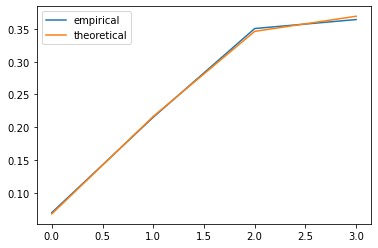

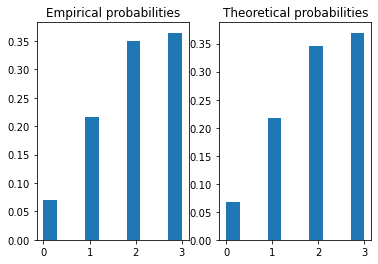

In [139]:
number_of_channels = 3
intensity_flow = 4
avg_processing_time = 0.8
intensity_flow_service = 1 / avg_processing_time
income_from_one_request = 4
maintenance_of_one_channel = 2
max_requests_num = 1000

model = SystemOfMassServiceModel(number_of_channels, intensity_flow, avg_processing_time, intensity_flow_service, income_from_one_request, maintenance_of_one_channel, max_requests_num)
model.modeling()
print(f'MODELING WITH THE NEXT PARAMETERS: Number Of Channels = {model.number_of_channels}, Intensity Flow = {model.intensity_flow}, \
      Average Processing Time = {avg_processing_time}, Income From One Request = {income_from_one_request}, Maintenance Of One Channel: {maintenance_of_one_channel}')
model_characteristics = CharacteristicsShower(model)
model_characteristics.plot_graphs()

# Вывод: после добавления еще одного канала обслуживания (n = 3) мы получили доход в 10 денежных единиц в час, что на 2.87 больше, чем при двухканальной системе. При этом затраты на обслуживание увеличились на 2 денежные единицы в час. Соответственно, трехканальная система является более выгодным вариантом.  